# Spaceship Titanic

Filename: spaceship.ipynb \
Author: Timothy Holland \
Last updated: 20/06/2024 \
Kaggle competition: https://www.kaggle.com/competitions/spaceship-titanic/data

## Data Processing

#### Importing

In [1]:
import pandas as pd
import numpy as np

# Import the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [2]:
# Separate the target variable
X_train = train_data.drop(['Transported'], axis=1)
y_train = train_data['Transported']
X_test = test_data
X_test_id = test_data['PassengerId']

In [3]:
print("Train dataset shape:", X_train.shape)
print("Test dataset shape:", X_test.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Train dataset shape: (8693, 13)
Test dataset shape: (4277, 13)
X_train shape: (8693, 13)
y_train shape: (8693,)


#### Analysing

In [4]:
# Print the first few rows of the train dataset
print(train_data.head())

print()
# Get information about the dataset
print(train_data.info())

print()
# Check for missing values
print(train_data.isnull().sum())

print()
# Get summary statistics
print(train_data.describe())

print()
# Check the distribution of the target variable
print(y_train.value_counts())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  

<

#### Transforming features

In [5]:
import pandas as pd

# Function to split the Cabin feature into separate columns
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Num'] = pd.to_numeric(df['Num'], errors='coerce')
    df.drop('Cabin', axis=1, inplace=True)
    return df

# Function to process PassengerId
def process_passenger_id(df):
    df[['GroupId', 'PassengerNum']] = df['PassengerId'].str.split('_', expand=True)
    df['PassengerNum'] = pd.to_numeric(df['PassengerNum'])
    df['GroupSize'] = df.groupby('GroupId')['PassengerId'].transform('count')
    df['IsSoloTraveler'] = (df['GroupSize'] == 1).astype(int)
    df.drop(['PassengerId', 'GroupId'], axis=1, inplace=True)
    return df

# Function to process Name
def process_name(df):
    df['LastName'] = df['Name'].str.split().str[-1]
    df['LastNameFrequency'] = df.groupby('LastName')['LastName'].transform('count')
    df.drop(['Name', 'LastName'], axis=1, inplace=True)
    return df

# Apply the transformations to the training dataset
X_train_transformed = X_train.copy()
X_train_transformed = split_cabin(X_train_transformed)
X_train_transformed = process_passenger_id(X_train_transformed)
X_train_transformed = process_name(X_train_transformed)

# Apply the transformations to the test dataset
X_test_transformed = X_test.copy()
X_test_transformed = split_cabin(X_test_transformed)
X_test_transformed = process_passenger_id(X_test_transformed)
X_test_transformed = process_name(X_test_transformed)

# Print the updated dataset information
print("Transformed Training Dataset:")
print(X_train_transformed.info())

print("\nTransformed Test Dataset:")
print(X_test_transformed.info())

# Print the first few rows of the transformed datasets
print("\nTransformed Training Dataset (first few rows):")
print(X_train_transformed.head())

print("\nTransformed Test Dataset (first few rows):")
print(X_test_transformed.head())

Transformed Training Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8492 non-null   object 
 1   CryoSleep          8476 non-null   object 
 2   Destination        8511 non-null   object 
 3   Age                8514 non-null   float64
 4   VIP                8490 non-null   object 
 5   RoomService        8512 non-null   float64
 6   FoodCourt          8510 non-null   float64
 7   ShoppingMall       8485 non-null   float64
 8   Spa                8510 non-null   float64
 9   VRDeck             8505 non-null   float64
 10  Deck               8494 non-null   object 
 11  Num                8494 non-null   float64
 12  Side               8494 non-null   object 
 13  PassengerNum       8693 non-null   int64  
 14  GroupSize          8693 non-null   int64  
 15  IsSoloTraveler     8693 non-null   int64  

#### Encoding categorical variables

In [6]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns (excluding 'VIP' and 'CryoSleep')
categorical_cols = X_train_transformed.select_dtypes(include=['object', 'category']).columns
categorical_cols = [col for col in categorical_cols if col not in ['VIP', 'CryoSleep']]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the training data
encoder.fit(X_train_transformed[categorical_cols])

# Function to encode dataframe
def encode_dataframe(df):
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Binary encode 'VIP' and 'CryoSleep' columns, handling NaN values
    binary_cols = ['VIP', 'CryoSleep']
    df_binary = pd.get_dummies(df[binary_cols], prefix=binary_cols, dummy_na=True)
    
    # One-hot encode other categorical columns
    encoded_cats = pd.DataFrame(encoder.transform(df[categorical_cols]).toarray(),
                                columns=encoder.get_feature_names_out(categorical_cols))
    
    # Combine encoded categorical columns with binary encoded columns and non-categorical columns
    non_cat_cols = df.columns.difference(categorical_cols + binary_cols)
    encoded_df = pd.concat([df[non_cat_cols], df_binary, encoded_cats], axis=1)
    
    return encoded_df

# Encode training data
X_train_encoded = encode_dataframe(X_train_transformed)

# Encode test data
X_test_encoded = encode_dataframe(X_test_transformed)

print("Shape of X_train_encoded:", X_train_encoded.shape)
print("Shape of X_test_encoded:", X_test_encoded.shape)

Shape of X_train_encoded: (8693, 37)
Shape of X_test_encoded: (4277, 37)


#### Numeric correlation with target variable

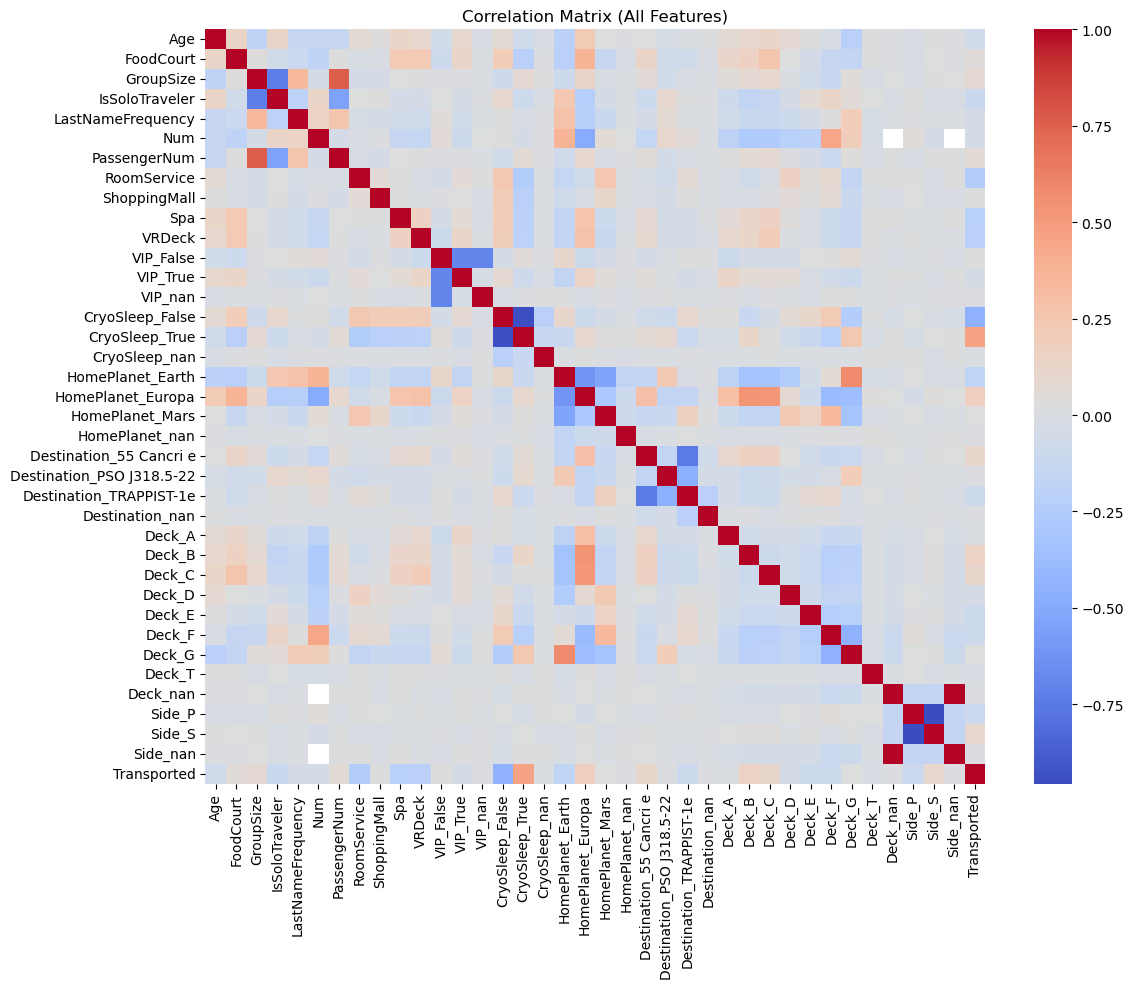

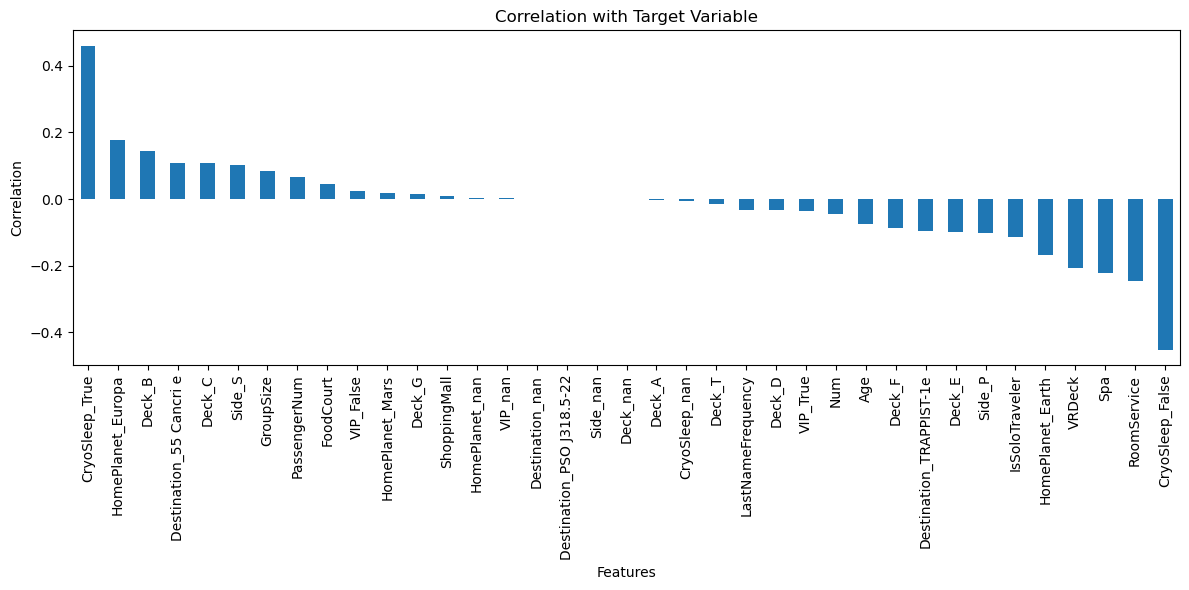

Top 10 correlations with target variable:
CryoSleep_True             0.460132
CryoSleep_False            0.451744
RoomService                0.244611
Spa                        0.221131
VRDeck                     0.207075
HomePlanet_Europa          0.176916
HomePlanet_Earth           0.169019
Deck_B                     0.144733
IsSoloTraveler             0.113792
Destination_55 Cancri e    0.108722
Name: Transported, dtype: float64


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Combine encoded features with target variable
train_data_encoded = pd.concat([X_train_encoded, y_train], axis=1)

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(train_data_encoded.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix (All Features)')
plt.tight_layout()
plt.show()

# Correlation with target variable
corr_target = train_data_encoded.corr()[y_train.name].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
corr_target.drop(y_train.name).plot(kind='bar')
plt.title('Correlation with Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

# Print top 10 correlations
print("Top 10 correlations with target variable:")
print(corr_target.drop(y_train.name).abs().sort_values(ascending=False).head(10))

#### Scale & Impute Missing Numeric Values

In [8]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Create the scaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train_encoded)

# Scale the training and test data
X_train_scaled = scaler.transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Create the KNNImputer object
imputer = KNNImputer(n_neighbors=20)

# Fit the imputer on the scaled training data
imputer.fit(X_train_scaled)

# Impute missing values in the scaled training and test data
X_train_imputed = pd.DataFrame(imputer.transform(X_train_scaled), columns=X_train_encoded.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_scaled), columns=X_test_encoded.columns)

# Check for missing values in datasets
train_missing = X_train_imputed.isnull().sum()
print("Missing values in training set after imputation:")
print(train_missing)
print(f"Total missing values in training set: {train_missing.sum()}")

test_missing = X_test_imputed.isnull().sum()
print("\nMissing values in test set after imputation:")
print(test_missing)
print(f"Total missing values in test set: {test_missing.sum()}")

# Verify that there are no NaN or infinite values
print("\nAny NaN values in training set:", np.isnan(X_train_imputed).any())
print("Any infinite values in training set:", np.isinf(X_train_imputed).any())
print("Any NaN values in test set:", np.isnan(X_test_imputed).any())
print("Any infinite values in test set:", np.isinf(X_test_imputed).any())


Missing values in training set after imputation:
Age                          0
FoodCourt                    0
GroupSize                    0
IsSoloTraveler               0
LastNameFrequency            0
Num                          0
PassengerNum                 0
RoomService                  0
ShoppingMall                 0
Spa                          0
VRDeck                       0
VIP_False                    0
VIP_True                     0
VIP_nan                      0
CryoSleep_False              0
CryoSleep_True               0
CryoSleep_nan                0
HomePlanet_Earth             0
HomePlanet_Europa            0
HomePlanet_Mars              0
HomePlanet_nan               0
Destination_55 Cancri e      0
Destination_PSO J318.5-22    0
Destination_TRAPPIST-1e      0
Destination_nan              0
Deck_A                       0
Deck_B                       0
Deck_C                       0
Deck_D                       0
Deck_E                       0
Deck_F               

## Models

In [10]:
# Final datasets to be used
X_train_final = X_train_imputed
y_train_final  = y_train
X_test_final = X_test_imputed

print(X_train_final.shape)
print(X_test_final.shape)


(8693, 37)
(4277, 37)


#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# Define the main parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000],
}

# Param grid for elasticnet
elasticnet_param = {
    'penalty': ['elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],  # only saga supports elasticnet
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
}

param_grid.update(elasticnet_param)

# Create LR model and perform CV
model = LogisticRegression(random_state=42)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_final, y_train_final)

print("Best hyperparameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# Evaluate best model
best_lr_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_lr_model, X_train_final, y_train_final, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))
print("Standard deviation of CV scores:", np.std(cv_scores))

# Train the best model on the entire training set
best_lr_model.fit(X_train_final, y_train_final)

#### KNN

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define the hyperparameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Create a KNN classifier object
knn = KNeighborsClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train_final)

# Print the best hyperparameters and the corresponding accuracy score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy Score: ", grid_search.best_score_)

# Get the best estimator (KNN model with optimal hyperparameters)
best_knn = grid_search.best_estimator_

# Evaluate the best KNN model using cross-validation
scores = cross_val_score(best_knn, X_train_final, y_train_final, cv=5, scoring='accuracy')
print("Cross-Validation Scores: ", scores)
print("Average Accuracy: ", scores.mean())

Best Hyperparameters:  {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Best Accuracy Score:  0.7558963757724868
Cross-Validation Scores:  [0.74583094 0.75043128 0.76423232 0.78135788 0.73762946]
Average Accuracy:  0.7558963757724868


#### Random Forest

In [36]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [30, 40, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
}

# Perform grid search
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_final, y_train_final)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_rf = grid_search.best_estimator_

# Train the best model on the entire training set
best_rf.fit(X_train_final, y_train_final)

Best parameters: {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score: 0.7984624709914232


RandomForestClassifier(max_depth=40, min_samples_leaf=4, min_samples_split=5,
                       n_estimators=300, random_state=42)

#### Naive Bayes

In [43]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Assuming X_train_final and y_train_final are already defined
# If not, replace them with your actual feature matrix and target vector

# Step 2: Compute the correlation matrix
corr_matrix = pd.DataFrame(X_train_final).corr().abs()

# Step 3: Select uncorrelated features
correlation_threshold = 0.7
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > correlation_threshold)]
X_uncorrelated = pd.DataFrame(X_train_final).drop(to_drop, axis=1)

# Step 4: Compute mutual information scores
mi_scores = mutual_info_classif(X_uncorrelated, y_train_final)

# Step 5: Select top features based on mutual information
num_top_features = 10  # You can adjust this number
top_features = X_uncorrelated.columns[np.argsort(mi_scores)[-num_top_features:]]

# Step 6: Create the final feature set
X_final = X_uncorrelated[top_features]

# Step 7: Train and evaluate the Naive Bayes classifier
nb_classifier = GaussianNB()
scores = cross_val_score(nb_classifier, X_final, y_train_final, cv=5, scoring='accuracy')

print(f"Selected features: {', '.join(top_features)}")
print(f"Cross-validation accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Optional: Train final model on entire dataset
final_model = GaussianNB()
final_model.fit(X_final, y_train_final)

Selected features: Deck_E, Destination_55 Cancri e, HomePlanet_Europa, Num, FoodCourt, ShoppingMall, VRDeck, RoomService, Spa, CryoSleep_False
Cross-validation accuracy: 0.7107 (+/- 0.0401)


GaussianNB()

#### MLP

In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X_train_final and y_train_final are already defined

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=42)

# Define the model
def create_model(neurons=64, dropout_rate=0.3, learning_rate=0.001, regularization=0.01):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(regularization)),
        Dropout(dropout_rate),
        Dense(neurons // 2, activation='relu', kernel_regularizer=l2(regularization)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the hyperparameter search space
param_dist = {
    'neurons': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.0001, 0.001, 0.01],
    'regularization': [0.01, 0.1, 0.001]
}

# Perform random search
best_params = None
best_score = 0
num_iterations = 10

for _ in range(num_iterations):
    # Sample hyperparameters
    params = {k: np.random.choice(v) for k, v in param_dist.items()}
    
    # Create and train the model
    model = create_model(**params)
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    
    # Update best parameters and score
    if val_accuracy > best_score:
        best_params = params
        best_score = val_accuracy

# Print the best parameters and score
print("Best parameters:", best_params)
print("Best validation accuracy:", best_score)

# Train the final model with the best parameters
best_model = create_model(**best_params)
best_model.fit(X_train_final, y_train_final, epochs=50, batch_size=32, verbose=0)

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(X_train_final, y_train_final, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_proba = best_model.predict(X_train_final)
y_pred = (y_pred_proba > 0.5).astype(int)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwa

Best parameters: {'neurons': 64, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'regularization': 0.001}
Best validation accuracy: 0.7924094200134277


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test accuracy: 0.7912
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step


#### SVM

In [75]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

# Define the parameter grid for tuning
param_grid = {
    'C': [1, 10, 100],
    'kernel': ['linear'],
    'gamma': ['scale', 'auto']
}

# Create an SVM instance
svm_model = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_final, y_train_final)

# Print the best hyperparameters and score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

# Evaluate the best model using cross-validation
best_model = grid_search.best_estimator_
scores = cross_val_score(best_model, X_train_scaled, y_train_final, cv=5, scoring='accuracy')
print("Mean Accuracy: ", np.mean(scores))

Best Hyperparameters:  {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Accuracy:  0.7948927700072328
Mean Accuracy:  0.7951227872585266


## Predictions

In [73]:
# Defining best model
best_model = model

In [76]:
import pandas as pd

# Get predictions from the trained model
predictions = best_model.predict(X_test_final)

# Convert to binary predictions
y_pred_binary = (predictions > 0.5).astype(int)
y_pred = y_pred_binary.reshape(-1)

# Create a DataFrame with PassengerId and Transported columns
submission = pd.DataFrame({
    'PassengerId': X_test_id,
    'Transported': y_pred
})

# Convert Transported to boolean
submission['Transported'] = submission['Transported'].astype(bool)

# Save the submission DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)